Using the data collected from Chromatic Resolution Zemax.py to define the shape of the optics beams and the feed horn aperture illumination, we can define the spectral bandpasses of each feed horn in the TIM focal plane array. Due to the smile in the system, a curved line of field points is imaged to each row of spectral pixels. Due to the keystone, a different wavelength is imaged to each column of spatial pixels. We account for these effects plus the mismatch between the beam shape and aperture illumination.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sps
import time, sys
from IPython.display import clear_output

In [2]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# Plot in the input data
def plot_spectrometer(ax, data1, data2, param_dict):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    return out

In [3]:
# Filepath to the output data stored in a numpy array
filePath = 'TIM_ChromaticResData.npy'
# data is stored in a dictionary with the keys: 'SW' and 'LW', which are dictionaries, 
# each with keys, 'SFNO', 'TFNO', 'CENX', and 'CENY'. Each entry is a numpy array 
# whose rows are fields and columns are wavelegnths
data = np.load(filePath).item() 
# Accidental switching of names when generating data, so switch back here until new data is collected.
SWdata = data['LW']
LWdata = data['SW']
# Flip the orientation of the X axis of the SW module
SWdata['CENX'] = -1*SWdata['CENX']
numFields = len(SWdata['CENX'])
numWavs = len(SWdata['CENX'][0])
# Parameters used to generate data
SW1 = 240
SW2 = 317
LW1 = 317
LW2 = 420
F1 = -0.18
F2 = 0.18
wavs_SW = np.linspace(SW1,SW2,numWavs)
wavs_LW = np.linspace(LW1,LW2,numWavs)
fields = np.linspace(F1,F2,numFields)

### Slow Calculation
Need to try to parallelize the loops, or come up with a way to use matrix operations to compute all data.
All matrix operations I tried by broadcasting ran out of memory because I tried to create many large dimensioned arrays.

In [29]:
# Define feed horn center coordinates
numPixX = 72
numPixY = 25
pixelPitch = 2.3
# X axis data starts at 0, while Y axis data is centered at 0.
x_fpa = np.linspace(0,numPixX*pixelPitch,numPixX)
y_fpa = np.linspace(-numPixY/2*pixelPitch,numPixY/2*pixelPitch,numPixY)
X_fpa,Y_fpa = np.meshgrid(x_fpa, y_fpa, sparse=False, indexing='xy')

# To compute the PSF based on the F/#, we arbitrarily set the 'pupil' distance as z = 1,
# which yields that the pupil semi-diameter is: a = 1/2*Fnum based on making the approx. that
# z/a = 2*Fnum.
#
# Fraunhofer diffraction from an elliptical aperture is used as the PSF.
# Ref. Far-Field Radiation Patterns of Ellipitcal Apertures and Its Annulli by Y.P. Kathuria
#
# Compute the Fraunhofer diffraction pattern at all feed horn positions for all fields and wavelengths.
# We sample the diffraction pattern wtih a grid of points covering the feed horn aperture (2 mm diameter).
x_ap = np.linspace(-1,1,11)
y_ap = np.linspace(-1,1,11)
X_ap,Y_ap = np.meshgrid(x_ap, y_ap, sparse=False, indexing='xy')

SW_PSF = np.empty([len(y_fpa),len(x_fpa),numFields,numWavs,len(y_ap),len(x_ap)])
LW_PSF = np.empty([len(y_fpa),len(x_fpa),numFields,numWavs,len(y_ap),len(x_ap)])

num_loops = numFields*numWavs
for f in range(numFields):
    for w in range(numWavs):
        update_progress((f*numWavs + w)/ num_loops)
        a_x_LW = 1/(2*LWdata['TFNO'][f,w])
        a_y_LW = 1/(2*LWdata['SFNO'][f,w])
        k_LW = 2*np.pi/wavs_LW[w]
        
        a_x_SW = 1/(2*SWdata['TFNO'][f,w])
        a_y_SW = 1/(2*SWdata['SFNO'][f,w])
        # Convert from micrometers to mm
        k_SW = 2*np.pi/(wavs_SW[w]/1000)
        
        x_beam_LW = LWdata['CENX'][f,w]
        y_beam_LW = LWdata['CENY'][f,w]
        
        x_beam_SW = SWdata['CENX'][f,w]
        y_beam_SW = SWdata['CENY'][f,w]

        for i in range(len(y_fpa)):
            for j in range(len(x_fpa)):
                K_LW = k_LW*np.sqrt(np.power(a_x_LW*(X_ap-X_fpa[i,j]+x_beam_LW),2)
                                 + np.power(a_y_LW*(Y_ap-Y_fpa[i,j]+y_beam_LW),2))

                K_SW = k_SW*np.sqrt(np.power(a_x_SW*(X_ap-X_fpa[i,j]+x_beam_SW),2)
                                 + np.power(a_y_SW*(Y_ap-Y_fpa[i,j]+y_beam_SW),2))
                
                SW_PSF[i,j,f,w,:,:] = np.power(2*sps.j0(K_SW)/K_SW,2)
                LW_PSF[i,j,f,w,:,:] = np.power(2*sps.j0(K_LW)/K_LW,2)
update_progress(1)

Progress: [####################] 100.0%


In [49]:
# Multiply every PSF by the aperture illumination function evaluated at the specific wavelength.
# Sum all entries in the resulting array and divide by area to get an approximate irradiance.
# For a particular i,j (feed horn), plot irradiance vs. wavelength for all fields. If we don't care about
# separate fields contributing to a single feed horn, we can even sum along the field dimension.
# This yields the bandpass of the feed horn.
SW_Band = np.sum(np.sum(SW_PSF, axis=5), axis=4)

In [51]:
SW_Band.shape

(25, 72, 25, 200)

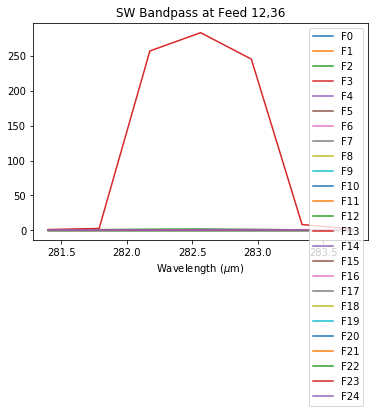

In [53]:
fig, ax = plt.subplots()
start = 107
stop = 114
for f in range(numFields):
    plot_spectrometer(ax, wavs_SW[start:stop], SW_Band[12,36,f,start:stop], {'label': 'F{}'.format(f)})
ax.set_title('SW Bandpass at Feed {},{}'.format(12,36))
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.legend();

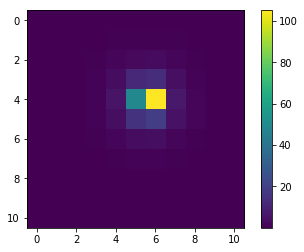

In [55]:
fig, ax = plt.subplots()
im = ax.imshow(SW_PSF[12,36,13,110,:,:])
plt.colorbar(im)
plt.show()